# Распознавание автомобильных номеров с помощью глубоких нейронных сетей
Проект выполнили: Мовенко Константин, Андрей Ларин

## Условие задачи

Системы распознавания автомобильных номеров состоят из двух модулей: детекция и распознавание символов (`Optical Character Recognition, OCR`). Детектор выделяет прямоугольник с номером из изображения, а `OCR` конвертирует его в текст. Будем считать, что детектор уже реализован. В рамках вступительного экзамена предлагается самостоятельно обучить модель `OCR` для автомобильных номеров.

**Предлагаемая архитектура решения**:

Предлагается реализовать модель, состоящую из двух блоков: 

- `FCNN` (Fully-convolutional CNN)
- `Bi-LSTM`

На выходе предлагается использовать `Cross-entropy` или `CTC-loss`. Архитектура показана на рисунке ниже из данной [статьи](https://arxiv.org/abs/1507.05717), которую мы и будем реализовывать:

![RCNN Architecture](images/architecture_rcnn.png)

Главное ограничение — нельзя использовать предобученные веса модели.

**Корпус данных**

Предлагается использовать корпус [CCPD2019](https://github.com/detectRecog/CCPD). Специально для участников отбора мы выделили регионы интереса и распарсили метки из исходного корпуса. В `test` вошли изображения из `CCPD-weather`. Подготовленный корпус можно скачать по [ссылке](https://disk.yandex.ru/d/adjYzzNayB1pag).

## 1. Подготовка данных

Загрузим необходимые библиотеки для работы:

In [1]:
import os
import cv2
import tqdm
import json
import warnings
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as O
import albumentations as A

from string import digits, ascii_uppercase
from pathlib import Path
from collections import Counter, OrderedDict, namedtuple

from torchvision import models as M
from torchvision import transforms as T

warnings.filterwarnings("ignore")

In [2]:
directory = r'C:\Users\kosta\Documents\Учёба\СДЕЛАНО\6 семестр\ППцП\CCPD2019-dl1'
contents = os.listdir(directory)
print(contents)

['test', 'train']


Зададим пути для тренировочной и тестовой выборки:

In [3]:
ROOT_DIR = Path(r'C:/Users/kosta/Documents/Учёба/СДЕЛАНО/6 семестр/ППцП/CCPD2019-dl1')
TRAIN_DIR = ROOT_DIR / 'train'
TEST_DIR = ROOT_DIR / 'test'

Проверим, с каким количеством номеров мы работаем:

In [4]:
all_images_train = sorted(
    [x.name for x in TRAIN_DIR.glob("*")], 
    key=lambda x: int(x.split('-')[0])
)
all_images_test = sorted(
    [x.name for x in TEST_DIR.glob("*.jpg")]
)

В тренировочном наборе находится `199980` номеров, а в тестовом - `9999`:

In [5]:
len(all_images_train)

199979

In [6]:
len(all_images_test)

9999

Пример имени файла, с которыми будет проводится работа:

In [7]:
all_images_train[0]

'01-皖A15926.jpg'

Теперь посмотрим, как выглядят изображения, с которыми мы работаем в виде сетки изображений.

Сначала посмотрим на тренировочную выборку:

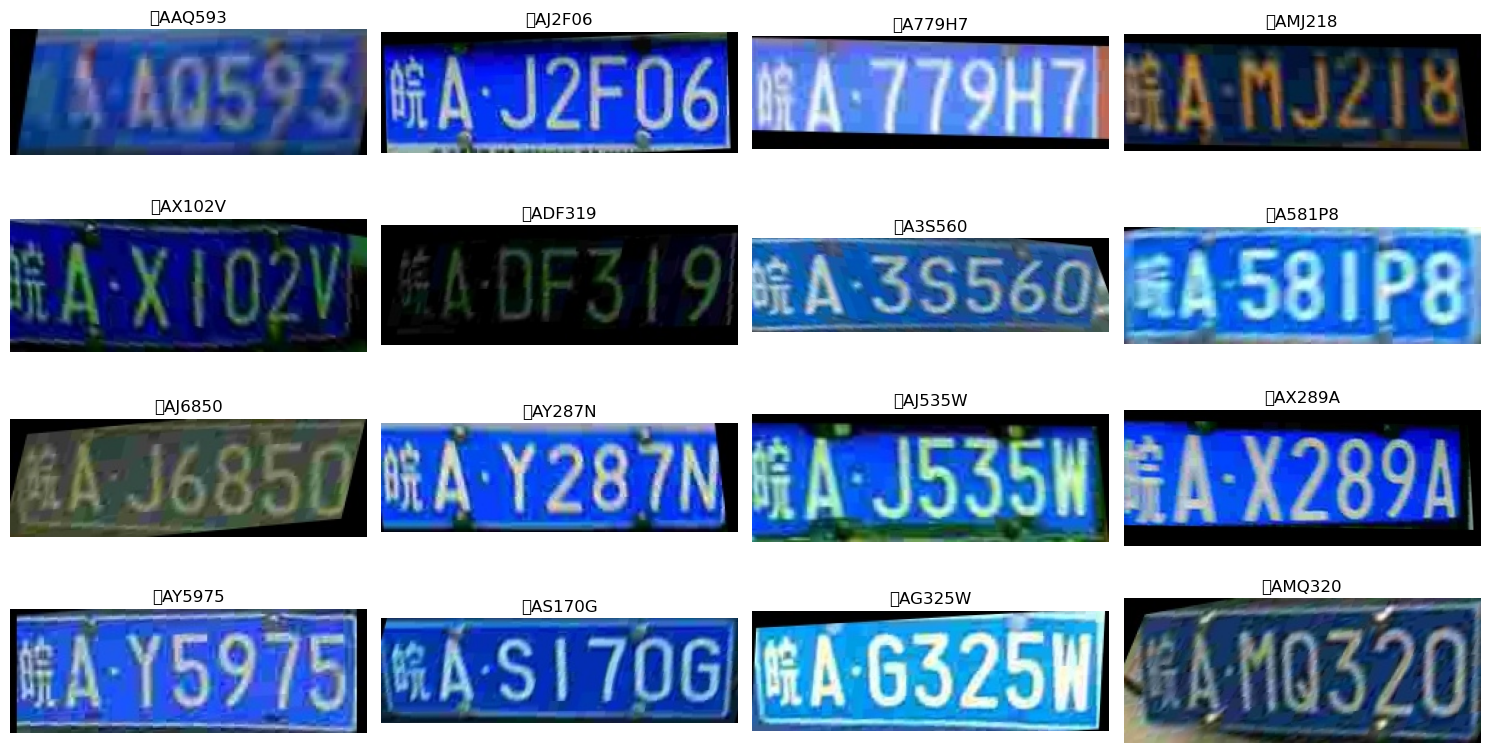

In [8]:
NUM_COLS = 4
SAMPLE_SIZE = NUM_COLS ** 2
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(all_images_train), size=SAMPLE_SIZE, replace=False)

plt.figure(figsize=(15, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    filename = all_images_train[idx]
    text = filename.split('-')[1].split('.')[0]
    image_path = os.path.join(TRAIN_DIR, filename)
    
    with open(image_path, 'rb') as f:
        image_data = f.read()
        image = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)

    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

А затем на тестовую:

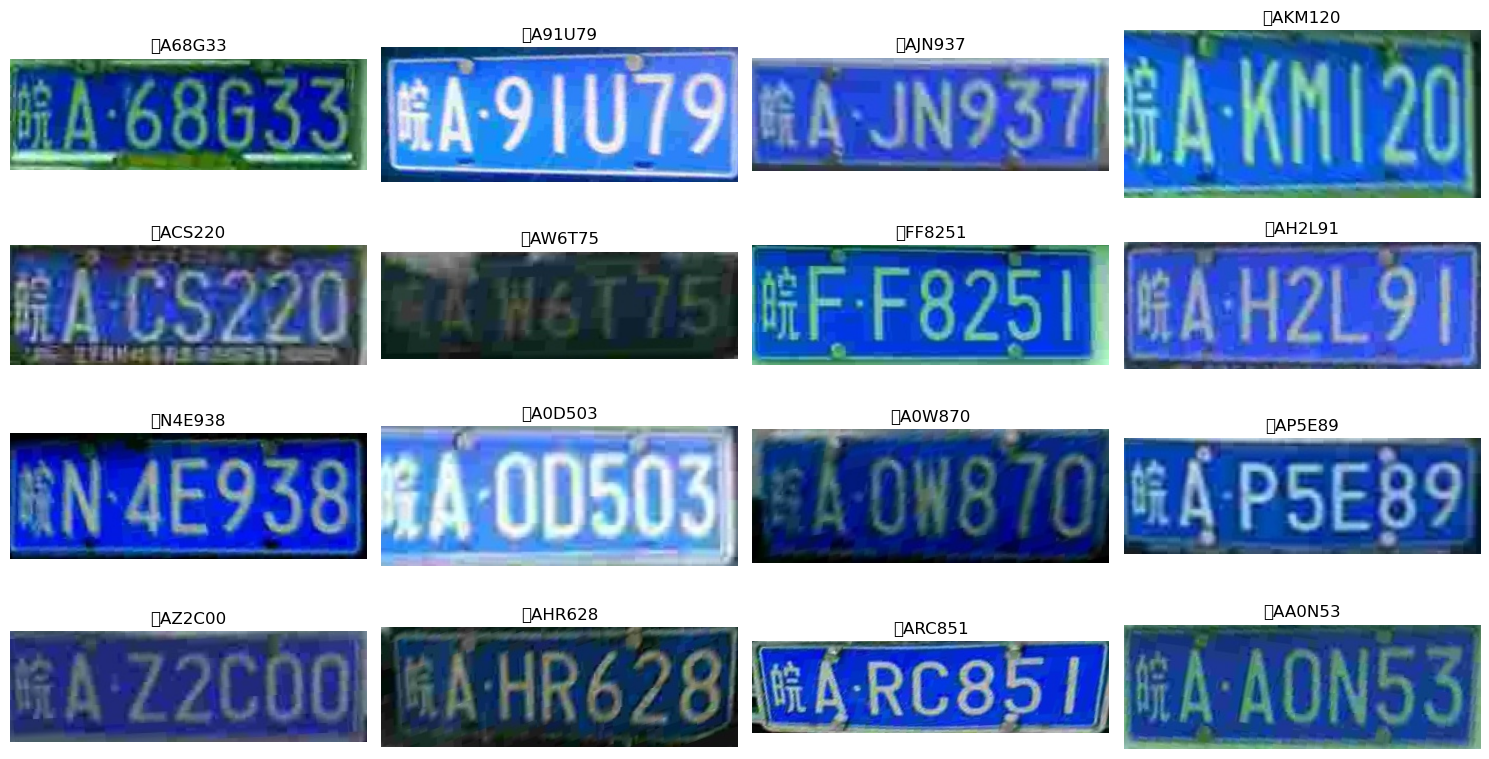

In [9]:
NUM_COLS = 4
SAMPLE_SIZE = NUM_COLS ** 2
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(
    len(all_images_test), 
    size=SAMPLE_SIZE, 
    replace=False
)

plt.figure(figsize=(15, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    filename = all_images_test[idx]
    text = filename.split('-')[1].split('.')[0]
    image_path = os.path.join(TEST_DIR, filename)
    
    with open(image_path, 'rb') as f:
        image_data = f.read()
        image = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)

    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

Структура данных одинаковая - прямоугольные изображения с китайскими номерами с различным качеством фотографий (присутствует размытие, зашумленность).

Рассмотрим формат входных данных, взятый с официальной страницы данных:

Каждое изображение в CCPD имеет только один номерной знак. Каждый знак состоит из: китайского иероглифа (символ провинции), латинской буквы и набора из пяти букв и цифр.

К каждому номерному знаку в датасете прикреплён набор из 13 цифр. Это – индексы соответствующих символов в номере. Для иероглифов, первой буквы и 5-значного кода индексация берётся по соответствующим массивам.

```
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']
```

То есть каждый номер должен состоять из 7-ми символов - проверим, так ли это:

In [10]:
train_im = pd.DataFrame({'x': Counter([x.split('-')[1] for x in all_images_train])})
test_im = pd.DataFrame({'x': Counter([x.split('-')[1] for x in all_images_test])})
train_numbers = Counter([len(x.split('.')[0]) for x in train_im.index])
test_numbers = Counter([len(x.split('.')[0]) for x in test_im.index])
train_numbers, test_numbers

(Counter({7: 144206}), Counter({7: 9292}))

Создадим список символов, которые могут встречаться в номерах - в него входят буквы, цифры и китайские иероглифы (кроме латинской O):

In [11]:
all_letters = Counter()

for o, i in tqdm.tqdm(enumerate(train_im.index)):
    f = i.split('.')[0]
    for f1 in f:
        all_letters.update({f1: 1})

abc = ''.join(filter(lambda x: x != 'O', sorted(list(all_letters.keys()))))
print(abc)
len(abc)

144206it [00:01, 108030.30it/s]

0123456789ABCDEFGHJKLMNPQRSTUVWXYZ云京冀吉宁川新晋桂沪津浙渝湘琼甘皖粤苏蒙藏豫贵赣辽鄂闽陕青鲁黑


65

Перед созданием датасета создадим класс для применения аугментации для номерных знаков с помощью библиотеки `albumentations` - добавим аугментацию для тренировочной выборки и исключим для тестовой.

В классе `Resize` будем считывать исходное изображение и изменять размер для введённого нами:

In [12]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.
        
        Args: 
            - item: Dict with keys "image", "seq", "seq_len", "text".
        
        Returns: 
            Dict with image resized to self.size.
        """
        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)
        
        return item

Напишем интерфейсы для применения данных аугментаций:

In [13]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, item):
        for t in self.transforms:
            item = t(item)
        return item
    
class PreparedAug:

    def __init__(self):
        augmentation = [
            A.Rotate(limit=10, p=0.5),
            A.GaussianBlur(p=0.4),
        ]
        self.augmentation = A.Compose(augmentation)

    def __call__(self, item):
        item['image'] = self.augmentation(image=item['image'])['image']
        return item
    

class DefaultAugmentations:
    """
    Resize + Augmentation
    """
    def __init__(self, size):
        self.augment = Compose(
            [
                Resize(size=size),
                PreparedAug()
            ]
        )

    def __call__(self, item):
        return self.augment(item)


class ValidationAugmentations:
    """
    Только Resize изображений
    """
    def __init__(self, size):
        self.augment = Compose(
            [
                Resize(size=size),
            ]
        )

    def __call__(self, item):
        return self.augment(item)

Перейдем к созданию кастомного класса `Dataset`. В методе `__getitem__` будем возвращать словарь со следующими атрибутами:

- `image` - изображение номера после применения `Resize` и/или аугментации фиксированного размера `HxWx3`
- `seq` - закодированную последовательность, где каждая буква соотвествует своему номеру (всего букв 65 и первый символ зададим для отсутствующего символа `O` (пропуск))
- `seq_len` - длина закодированной последовательности для `CTC-loss`

Запишем данные по обучению и тесту в один `dataframe` с указанием файлов, типа данных (`[train, test]`) и пути:

In [14]:
train_data = pd.concat(
    [
        pd.DataFrame({'filename': all_images_train, 'train_type': 'train', 'dir': TRAIN_DIR}),
        pd.DataFrame({'filename': all_images_test, 'train_type': 'test', 'dir': TEST_DIR})
    ]
).reset_index(drop=True)
train_data.head()

,filename,train_type,dir
0,01-皖A15926.jpg,train,C:\Users\kosta\Documents\Учёба\СДЕЛАНО\6 семес...
1,01-皖A38P65.jpg,train,C:\Users\kosta\Documents\Учёба\СДЕЛАНО\6 семес...
2,01-皖A48679.jpg,train,C:\Users\kosta\Documents\Учёба\СДЕЛАНО\6 семес...
3,01-皖A5M877.jpg,train,C:\Users\kosta\Documents\Учёба\СДЕЛАНО\6 семес...
4,01-皖A61570.jpg,train,C:\Users\kosta\Documents\Учёба\СДЕЛАНО\6 семес...


In [15]:
train_data.shape

(209978, 3)

А теперь создадим сам класс нашего датасета:

In [16]:
class RecognitionDataset(D.Dataset):
    def __init__(self, 
                 data: pd.DataFrame, 
                 alphabet=abc, 
                 transforms=None):
        super(RecognitionDataset, self).__init__()
        self.data = data
        self.alphabet = alphabet
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        """
        Output:
            image: np.ndarray[float32], [0, 1]
            seq: list[int]
            seq_len: int
            text: str
        """
        sample = self.data.loc[item]
        filename = sample['filename']
        if 'O' in filename:
            filename = filename.replace('O', '0')
        train_type = sample['train_type']
        text = filename.split('-')[1].split('.')[0]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        
        
        TRAIN_DIR = sample['dir']
        image_path = os.path.join(TRAIN_DIR, filename)

        with open(image_path, 'rb') as f:
            image_data = f.read()
            image = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
            image = image.astype(np.float32) / 255.
#         image = cv2.imread(str(sample['dir'] / filename)).astype(np.float32) / 255.

        output = dict(image=image, seq=seq, seq_len=seq_len, text=text, train_type=train_type)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        seq = [self.alphabet.find(c) + 1 for c in text]
        return seq

Проверим, что все работает корректно и мы можем обратиться по индексу к определенному номеру:

In [17]:
r2d = RecognitionDataset(
    data=train_data, 
    alphabet=abc, 
    transforms=DefaultAugmentations(size=(320, 64))
)

Image shape: (64, 320, 3)
Seq: [51, 11, 12, 2, 3, 3, 21] Seq_len: 7 . Train_type: train
Text: 皖AB122L


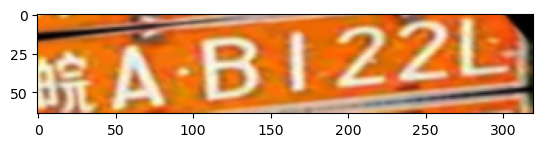

In [18]:
x = r2d[1000]
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"], ". Train_type:", x['train_type'])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()
    

Теперь реализуем функцию `collate_fn`, чтобы самостоятельно указать, как формировать батчи.

In [19]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts, train_type = [], [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
        train_type.append(item['train_type'])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts, 'train_type': train_type}
    return batch

Проверяем работоспособность:

In [20]:
xs = [r2d[i] for i in np.random.choice(range(len(r2d)), 5)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text', 'train_type'])


In [21]:
print("Image:"  , batch["image"  ].size())
print("Seq:"    , batch["seq"    ].size())
print("Seq:"    , batch["seq"    ])
print("Seq_len:", batch["seq_len"])
print("Text:"   , batch["text"   ])

Image: torch.Size([5, 3, 64, 320])
Seq: torch.Size([35])
Seq: tensor([51, 11, 33,  4, 12,  3, 10, 51, 11, 17,  6,  4,  3,  3, 51, 11, 14,  2,
        31,  7, 10, 51, 11,  1, 32,  3,  9,  1, 51, 11,  4,  1,  1, 14,  3],
       dtype=torch.int32)
Seq_len: tensor([7, 7, 7, 7, 7], dtype=torch.int32)
Text: ['皖AY3B29', '皖AG5322', '皖AD1W69', '皖A0X280', '皖A300D2']


## 2. Создание и обучение модели `CRNN`

### 2.1. `FCNN (Fully-convolutional CNN)`

Наша нейросеть состоит из двух частей - экстрактор фичей из изображений (реализуется через свёрточную сеть) и применение `Bi-LSTM` сетки. Реализуем независимо друг от друга две данные архитектуры:

Начнем с построения свёрточной сети - для этого реализуем `CNNBlock` для удобного её построения - применим несколько таких блоков.

In [40]:
class CNNBlock(nn.Module):

    def __init__(self, in_channels, out_channels, pool=True):
        super(CNNBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 
                               out_channels, 
                               kernel_size=(3, 3), 
                               padding=(1, 1), 
                               bias=False)
        self.conv2= nn.Conv2d(out_channels, 
                              out_channels, 
                              kernel_size=(3, 3), 
                              padding=(1, 1),
                              bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2= nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2)) if pool else nn.Identity()
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

Из данных блоков построим следующую свёрточную архитектуру, с помощью которой мы будем забирать фичи из изображений для подачи их в LSTM блок.

In [41]:
cnn_baseline = nn.Sequential(
    CNNBlock(3, 32),
    CNNBlock(32, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, output_channels)
)
cnn_baseline

NameError: name 'output_channels' is not defined

Создадим класс `FeatureExtractor`, в который подадим нашу сверточную сеть `cnn`, а также сделаем два архитектурных решения:

- добавим `AvgPool2d` по высоте, чтобы превратить выходной тензор в размерность `1 x (w // 32)`
- значение `w // 32`, которое мы будем подавать на вход LSTM может быть маленьким, поэтому применим свертку размером `1x1` вдоль размерности ширины, увеличим длину последовательности до входного параметра `output_len`.

In [42]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, cnn, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        self.cnn = cnn
        h, w = input_size
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
        self.num_output_features = self.cnn[-1].conv1.out_channels  
    
    def apply_projection(self, x):
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        features = self.cnn(x)
        features = self.pool(features)
        features = self.apply_projection(features) 
        return features

Проверим, что все работает корректно:

In [43]:
input_size =(64, 320)
output_len = 30
output_channels = 512

cnn_baseline = nn.Sequential(
    CNNBlock(3, 32),
    CNNBlock(32, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, output_channels)
)
cnn_baseline
feature_extractor = FeatureExtractor(
    cnn=cnn_baseline, 
    input_size=input_size, 
    output_len=output_len
)


x = torch.randn(1, 3, *input_size)
y = feature_extractor(x)
assert y.size() == (1, 1, output_channels, output_len)
assert feature_extractor.num_output_features == output_channels

Итог построения класса `FeaturesExtractor`:
- На вход получает тензор изображения размером `Bx3xHxW`
- На выходе отдает тензор признаков размером `Bx1xFxL`, где 
  - `F` - размерность вектора-токена (определяется числом признаков последнего сверточного слоя сверточной сети (задается опционально, но в нашем случае будем использовать значение `output_channels=512`)), 
  - `L` - "длина последовательности" токенов (`self.output_len`).

### 2.2. `BI-LSTM (Reccurent Part)`

Теперь напишем класс для рекуррентной части пайплайна `BI-LSTM`:

Будем использовать `LSTM` -  результат предсказаний после `LSTM` дополнительно проведем через линейный слой для формирования итоговой матрицы с `logits`. 

`LSTM` по умолчанию ожидает на вход тензор размера `L x B x F`, где:

- `L` - длина последовательности
- `B` - размер батча
- `F` - размер одного элемента последовательности. 

In [44]:
class SequencePredictor(nn.Module):
    
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 num_layers, 
                 num_classes, 
                 dropout=0.3, 
                 bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in, out_features=num_classes)
    
    def _init_hidden(self, batch_size):
        num_directions = 2 if self.rnn.bidirectional else 1
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        return h

        
    def _reshape_features(self, x):
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        c_0 = self._init_hidden(batch_size)
        c_0 = c_0.to(x.device)
        x, _, = self.rnn(x, (h_0, c_0)) 
        x = self.fc(x)
        return x

Проверим опять же, что всё работает корректно:

In [45]:
sequence_predictor = SequencePredictor(input_size=1280, 
                                       hidden_size=512, 
                                       num_layers=2, 
                                       num_classes=len(abc) + 1)

In [46]:
x = torch.randn(1, 1, 1280, 20)
assert sequence_predictor._reshape_features(x).size() == (20, 1, 1280)

In [47]:
y = sequence_predictor(x)
assert y.size() == (20, 1, 66)

### 2.3. CRNN

Собираем всё в один класс из двух выше описанных моделей:

In [48]:
class CRNN(nn.Module):
    def __init__(self, 
                 cnn,
                 alphabet=abc,
                 cnn_input_size=(64, 320), 
                 cnn_output_len=20,
                 rnn_hidden_size=128, 
                 rnn_num_layers=2, 
                 rnn_dropout=0.3, 
                 rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(
            cnn=cnn,
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=len(alphabet)+1,
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

Добавим функции декодирования результатов в буквенный (текстовой вид):

In [49]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

И опять проверим корректность работы:

In [50]:
crnn = CRNN(cnn_baseline, rnn_hidden_size=512)

In [51]:
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (20, 1, 66)

In [52]:
decode(y, abc)

['0津D0津5津浙C浙津0']

In [53]:
y.shape

torch.Size([20, 1, 66])

Обучаться будем с помощью `CTC-LOSS`. Перед тем, как подавать предсказания в лосс, необходимо применить к ним активацию `softmax` и затем взять логарифм.

## 3. Обучение и подсчёт метрик

Осталось написать интерфейсы для обучения и валидации, а также посчитать метрики. В данной работе будем использовать три метрики для оценки качества моделей:

- `Accuracy`
- `Character Error Rate` ([CER](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B5%D0%B2%D0%B5%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD%D0%B0))
- `Levenstein distance` (`rapidfuzz.distance.Levenshtein.distance`)

In [1]:
from torchmetrics import CharErrorRate
from rapidfuzz.distance.Levenshtein import distance

ModuleNotFoundError: No module named 'rapidfuzz'

In [63]:
char_error_rate = CharErrorRate()

Осталась техническая часть. Возьмем интерфейс для подсчета метрик:

In [61]:
class AverageMeter:
    def __init__(self, name):
        self.name = name
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __call__(self):
        return self.val, self.avg

Также напишем собственный интерфейс для тренировки модели по одной эпохе

In [64]:
def train_epoch(
    crnn: nn.Module,
    optimizer: O, 
    train_dataloader: D.DataLoader,
    epoch: int,
    device
):
    crnn.train()
    
    loss_stat = AverageMeter('Loss')
    leve_stat = AverageMeter('Levenstein Distance')
    cer_stat = AverageMeter('Levenstein Distance')
    acc_stat = AverageMeter('Accuracy')
    for step, b in enumerate(train_dataloader):
        num_of_samples = b['image'].shape[0]
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(log_probs=log_probs,
                          targets=seqs_gt,
                          input_lengths=seq_lens_pred,
                          target_lengths=seq_lens_gt)
        
        loss_stat.update(loss.detach().cpu().item(), num_of_samples)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                         
        predicts = decode(seqs_pred, abc)
        leve_dis = np.mean([distance(p, t) for p, t in zip(predicts, b['text'])])
        leve_stat.update(leve_dis, 1)
        
        cer_dis = char_error_rate(predicts, b['text'])
        cer_stat.update(cer_dis, 1)
        
        acc_dis = np.mean([p == t for p, t in zip(predicts, b['text'])])
        acc_stat.update(acc_dis, 1)
        
        if step % 200 == 0 and not step == 0:
            leve_val, leve_avg = leve_stat()
            loss_val, loss_avg = loss_stat()
            cer_val, cer_avg = cer_stat()
            acc_val, acc_avg = acc_stat()
            print(
                f'Train: epoch {epoch}. Step: {step}; loss: {loss_avg:.4}; levenstein: {leve_avg:.4}, cer: {cer_avg:.4}, acc: {acc_avg:.4}'
            )
    leve_val, leve_avg = leve_stat()
    loss_val, loss_avg = loss_stat()
    cer_val, cer_avg = cer_stat()
    acc_val, acc_avg = acc_stat()
            
    print(
        f'Train: epoch {epoch}. Step: {step}; loss: {loss_avg:.4}; levenstein: {leve_avg:.4}, cer: {cer_avg:.4}, acc: {acc_avg:.4}'
    )

А также для валидации:

In [65]:
def validate_epoch(
    crnn: nn.Module,
    val_dataloader: D.DataLoader,
    epoch: int,
    device
) -> int:
    crnn.eval()
    
    loss_stat = AverageMeter('Loss')
    leve_stat = AverageMeter('Levenstein Distance')
    cer_stat = AverageMeter('Levenstein Distance')
    acc_stat = AverageMeter('Accuracy')
    for step, b in enumerate(val_dataloader):
        num_of_samples = b['image'].shape[0]
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]
        
        with torch.no_grad():
            seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
        loss = F.ctc_loss(log_probs=log_probs,
                          targets=seqs_gt,
                          input_lengths=seq_lens_pred,
                          target_lengths=seq_lens_gt)
        loss_stat.update(loss.detach().cpu().item(), num_of_samples)
                         
        predicts = decode(seqs_pred, abc)
        
        leve_dis = np.mean([distance(p, t) for p, t in zip(predicts, b['text'])])
        leve_stat.update(leve_dis, 1)
        
        cer_dis = char_error_rate(predicts, b['text'])
        cer_stat.update(cer_dis, 1)
        
        acc_dis = np.mean([p == t for p, t in zip(predicts, b['text'])])
        acc_stat.update(acc_dis, 1)

    leve_val, leve_avg = leve_stat()
    loss_val, loss_avg = loss_stat()
    cer_val, cer_avg = cer_stat()
    acc_val, acc_avg = acc_stat()
            
    print(
        f'Validation: epoch {epoch}. Step: {step}; loss: {loss_avg:.4}; levenstein: {leve_avg:.4}, cer: {cer_avg:.4}, acc: {acc_avg:.4}'
    )
    return leve_avg

И напишем маленький интефейс для обучения и сохранения лучших результатов модели: будем обучаться на тренировочном наборе и валидироваться на тестовом.

In [66]:
def fit(train_data: pd.DataFrame, input_size=(96, 448), num_epochs=5, batch_size=128, num_workers=4):  
    reverse_size = tuple(list(input_size)[::-1])
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    crnn = CRNN(cnn_baseline, rnn_hidden_size=256, cnn_input_size=input_size)
    crnn.to(device)
    optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)
    train_data_numbers = train_data[train_data['train_type'] == 'train'].reset_index(drop=True)
    val_data_numbers = train_data[train_data['train_type'] == 'test'].reset_index(drop=True)
    
    train_dataset = RecognitionDataset(
        train_data_numbers, 
        transforms=DefaultAugmentations(size=reverse_size)
    )
    val_dataset = RecognitionDataset(
        val_data_numbers, 
        transforms=ValidationAugmentations(size=reverse_size)
    )
    
    train_dataloader = D.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
        pin_memory=True, 
        drop_last=True, 
        collate_fn=collate_fn
    )
    val_dataloader = D.DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=True, 
        drop_last=False, 
        collate_fn=collate_fn
    )
     
    print(len(train_dataloader), len(val_dataloader))
    
    best_leve = float("inf")
    best_model = None
    for epoch in range(num_epochs):
        train_epoch(crnn, optimizer, train_dataloader, epoch, device)
        leve_validation = validate_epoch(crnn, val_dataloader, epoch, device)
        if leve_validation <= best_leve:
            print(f'Best Levenstein distance: {leve_validation}')
            best_leve = leve_validation
            best_model = crnn
    return best_model, optimizer
    

И запустим обучение со следующими параметрами обучения:

- `num_epochs=5`
- `batch_size=128`
- `rnn_hidden_size=256`
- `num_channels_cnn_output=512`
- `optimizer` - `Adam(lr=3e-4)`
- `Resize(W, H) = (96, 448)` 

А затем с помощью с помощью `LSTM` блока:

In [67]:
bm2, opt2 = fit(train_data)

1562 79
Train: epoch 0. Step: 200; loss: 3.221; levenstein: 5.53, cer: 0.79, acc: 0.0
Train: epoch 0. Step: 400; loss: 2.816; levenstein: 5.296, cer: 0.7566, acc: 0.0
Train: epoch 0. Step: 600; loss: 2.471; levenstein: 4.759, cer: 0.6798, acc: 0.000169
Train: epoch 0. Step: 800; loss: 2.116; levenstein: 4.104, cer: 0.5862, acc: 0.01768
Train: epoch 0. Step: 1000; loss: 1.786; levenstein: 3.399, cer: 0.4856, acc: 0.1256
Train: epoch 0. Step: 1200; loss: 1.52; levenstein: 2.86, cer: 0.4085, acc: 0.248
Train: epoch 0. Step: 1400; loss: 1.318; levenstein: 2.464, cer: 0.3521, acc: 0.3436
Train: epoch 0. Step: 1561; loss: 1.19; levenstein: 2.217, cer: 0.3168, acc: 0.4048
Validation: epoch 0. Step: 78; loss: 0.08364; levenstein: 0.1182, cer: 0.01688, acc: 0.9023
Best Levenstein distance: 0.11815664556962024
Train: epoch 1. Step: 200; loss: 0.05502; levenstein: 0.05752, cer: 0.008218, acc: 0.9463
Train: epoch 1. Step: 400; loss: 0.0498; levenstein: 0.05223, cer: 0.007462, acc: 0.9509
Train: ep

Результаты обучения сетки - модель очень хорошо обучается и предскзывает с 97-процентной точностью. До этого обучил еще GRU блок и результаты были хуже - прикладываю обучение:

In [260]:
bm2, opt2 = fit(train_data)

1562 79
Train: epoch 0. Step: 200; loss: 2.904; levenstein: 5.399, cer: 0.7712, acc: 0.0
Train: epoch 0. Step: 400; loss: 2.231; levenstein: 4.235, cer: 0.6049, acc: 0.05964
Train: epoch 0. Step: 600; loss: 1.544; levenstein: 2.875, cer: 0.4108, acc: 0.3288
Train: epoch 0. Step: 800; loss: 1.173; levenstein: 2.172, cer: 0.3103, acc: 0.4824
Train: epoch 0. Step: 1000; loss: 0.9458; levenstein: 1.748, cer: 0.2496, acc: 0.5772
Train: epoch 0. Step: 1200; loss: 0.793; levenstein: 1.463, cer: 0.209, acc: 0.6416
Train: epoch 0. Step: 1400; loss: 0.6833; levenstein: 1.258, cer: 0.1798, acc: 0.6885
Train: epoch 0. Step: 1561; loss: 0.615; levenstein: 1.132, cer: 0.1617, acc: 0.7178
Validation: epoch 0. Step: 78; loss: 0.03386; levenstein: 0.06253, cer: 0.008933, acc: 0.9488
Best Levenstein distance: 0.0625329641350211
Train: epoch 1. Step: 200; loss: 0.02; levenstein: 0.02686, cer: 0.003837, acc: 0.9745
Train: epoch 1. Step: 400; loss: 0.01838; levenstein: 0.02476, cer: 0.003537, acc: 0.9763
T

Проанализируем, где же наша модель ошибается больше всего.

## 4. Анализ ошибок модели

Для начала сохраним обученную модель для воспроизводимости результатов:

In [68]:
def save_checkpoint(model, optimizer, filename):
    """Saves checkpoint to disk"""
    weights = model.state_dict()
    state = OrderedDict(
        [
            ('state_dict', weights),
            ('optimizer', optimizer.state_dict())
        ]
    )

    torch.save(state, filename)
    return filename

In [69]:
save_checkpoint(model=bm2, optimizer=opt2, filename='./crnn_lstm_tinkoff.pth')

'./crnn_lstm_tinkoff.pth'

Теперь предскажем текст на тестовых изображениях и сохраним результаты в таблицу предсказаний:

In [70]:
bm2.eval()

CRNN(
  (features_extractor): FeatureExtractor(
    (cnn): Sequential(
      (0): CNNBlock(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      )
      (1): CNNBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [71]:
device = (
    torch.device("cuda:0") 
    if torch.cuda.is_available() 
    else torch.device("cpu")
)

In [72]:
predicts = []


for test_image in tqdm.tqdm(all_images_test):
    test_filename = str(TEST_DIR / test_image)
    image = cv2.imread(test_filename).astype(np.float32) / 255.
    image = Resize((448, 96))(dict(image=image))['image']
    image = torch.from_numpy(image).permute(2, 0, 1).float().to(device)
    image = image[None]
    seq_preds = bm2(image)
    predicts.append(decode(seq_preds, abc))

100%|██████████| 9999/9999 [00:54<00:00, 182.62it/s]


In [73]:
prediction = pd.DataFrame(
    {
        'filename': all_images_test, 
        'true': [x.split('-')[1].split('.')[0] for x in all_images_test],
        'pred': predicts
    }
)
prediction['pred'] = prediction['pred'].apply(lambda x: x[0])

Посчитаем метрики на тестовом датасете:

- с помощью GRU-блока

In [275]:
levenstein_distance_test = np.mean(
    [
        distance(p, t) 
        for p, t in 
        zip(prediction['true'], prediction['pred'])
    ]
)
cer_test = char_error_rate(prediction['true'], prediction['pred']).item()
acc_test = np.mean(
    [
        p == t
        for p, t in 
        zip(prediction['true'], prediction['pred'])
    ]
)
print('Accuracy:', acc_test)
print('CER:', cer_test)
print('Levenstein:', levenstein_distance_test)

Accuracy: 0.9570957095709571
CER: 0.007136421278119087
Levenstein: 0.0499049904990499


- с помощью LSTM Блока

In [74]:
levenstein_distance_test = np.mean(
    [
        distance(p, t) 
        for p, t in 
        zip(prediction['true'], prediction['pred'])
    ]
)
cer_test = char_error_rate(prediction['true'], prediction['pred']).item()
acc_test = np.mean(
    [
        p == t
        for p, t in 
        zip(prediction['true'], prediction['pred'])
    ]
)
print('Accuracy:', acc_test)
print('CER:', cer_test)
print('Levenstein:', levenstein_distance_test)

Accuracy: 0.9752975297529753
CER: 0.004045284353196621
Levenstein: 0.028302830283028303


In [75]:
prediction['same'] = prediction['true'] == prediction['pred']
prediction.to_csv('./prediction_lstm.csv', index=False)

И проведем анализ ошибок - для этого возьмем результаты работы модели и выделим среди них те, в которых модель ошиблась.

In [77]:
errors = prediction[~(prediction['same'])].reset_index(drop=True)
print(errors.shape)
errors.head()

(247, 4)


,filename,true,pred,same
0,0042-皖AD130W.jpg,皖AD130W,皖AD130X,False
1,0045-皖AVD028.jpg,皖AVD028,皖AV0028,False
2,0046-皖RL222P.jpg,皖RL222P,皖BL222P,False
3,0050-皖ATG568.jpg,皖ATG568,皖AYG568,False
4,0086-皖A27N53.jpg,皖A27N53,皖A7N53,False


Видно, что ошибается модель достаточно мало. Сначала визуализиурем ошибочные сэмплы:

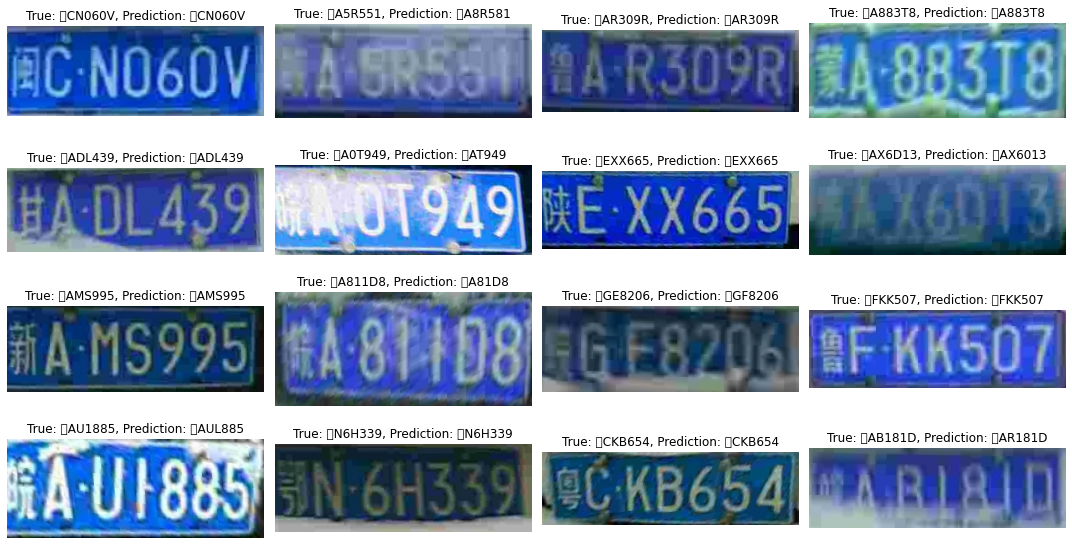

In [78]:
NUM_COLS = 4
SAMPLE_SIZE = NUM_COLS ** 2
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(
    len(errors), 
    size=SAMPLE_SIZE, 
    replace=False
)
plt.figure(figsize=(15, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    row = errors.loc[idx]
    filename = row['filename']
    true_text = row['true']
    pred_text = row['pred']
    image = cv2.imread(str(TEST_DIR / filename))
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(f'True: {true_text}, Prediction: {pred_text}')
    plt.axis("off")
    
plt.tight_layout()
plt.show()

А затем посчитаем, на каких символах модель больше всего ошибается (выведем `top-20`):

In [79]:
d = Counter()

for u, row in errors.iterrows():
    true_text = row['true']
    pred_text = row['pred']
    if len(true_text) == len(pred_text):
        for i, j in zip(true_text, pred_text):
            if i != j:
                d.update({f'{i}-{j}': 1})

In [80]:
d.most_common(20)

[('鲁-豫', 10),
 ('D-0', 8),
 ('粤-京', 6),
 ('赣-豫', 6),
 ('9-6', 5),
 ('0-Q', 5),
 ('浙-苏', 4),
 ('新-浙', 4),
 ('7-1', 4),
 ('鄂-豫', 4),
 ('津-鄂', 4),
 ('晋-鄂', 4),
 ('E-F', 3),
 ('蒙-豫', 3),
 ('湘-鄂', 3),
 ('赣-鄂', 3),
 ('冀-鄂', 3),
 ('闽-粤', 3),
 ('陕-豫', 3),
 ('2-3', 3)]

Мы видим, что модель частенько ошибается там, где мы это и ожидаем - не хватает детализации иероглифов (они похожи для дилентанта друг на друга), а также похожие буквы и цифры (`D-O`, `O-Q`, `E-F`), но ошибок таких не очень много. Возможные решения проблемы - увеличение размера входного изображений, величины `output_len`, более точная модель для сверточной сети. 

# Выводы

- был проведен качественный анализ данных и была выявлена ошибка в разметке;
- была написана классная архитектура модели и получены очень сильные результаты судя не только по метрикам, но и по ручном тестировании правильности результатов;
- были проанализированы места, в которых модель (довольно редко) ошибается и предложены пути их исправления;
- результаты модели воспроизводимы и могут быть использованы в дальнейшем.

Буду ждать результатов отборочного этапа! Надеюсь, услышимся на лекциях:)